# 10 Academy Week 10 – Task 4: Forecasting Access and Usage 2025–2027

**Objective**: Generate forecasts for
- **Access** → Account Ownership Rate (`ACC_OWNERSHIP`)
- **Usage** → Digital Payment Adoption Rate (proxied via available indicators)

for 2025, 2026, 2027 with uncertainty quantification and scenario analysis.

**Date**: February 02–03, 2026

**Approach given very sparse data** (only ~4–5 reliable Findex points):
1. Simple linear / log-linear trend on historical ownership
2. Add step interventions from Task 3 manual impact matrix (lagged effects)
3. Three scenarios: Baseline (no new events), Optimistic, Pessimistic
4. Wide confidence bands due to data limitations

**Key data points used** (from enriched dataset):
- 2014: 22%
- 2017: 35%
- 2021: 46%
- 2024: 49% (Findex 2025)

**Author**: [Your Name]

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set(style="whitegrid")

## 1. Load enriched data & extract historical Access series

In [6]:
df = pd.read_excel("../data/processed/ethiopia_fi_enriched_20260131.xlsx")

df_obs = df[df['record_type'] == 'observation'].copy()
df_obs['date'] = pd.to_datetime(df_obs['observation_date'], errors='coerce')
df_obs = df_obs.dropna(subset=['date'])

# Focus on ACC_OWNERSHIP
access = df_obs[df_obs['indicator_code'] == 'ACC_OWNERSHIP'].copy()
access = access[['date', 'value_numeric']].sort_values('date').reset_index(drop=True)

print("Historical Account Ownership points:")
print(access)

# For plotting later
years = access['date'].dt.year
values = access['value_numeric']

Historical Account Ownership points:
        date  value_numeric
0 2014-12-31           22.0
1 2017-12-31           35.0
2 2021-12-31           46.0
3 2021-12-31           56.0
4 2021-12-31           36.0
5 2024-11-29           49.0
6 2024-12-31           49.0


## 2. Simple Baseline Trend (no new events)

In [7]:
# Prepare numeric time variable (years since 2014)
access['t'] = (access['date'].dt.year - 2014).astype(int)

X = sm.add_constant(access['t'])
y = access['value_numeric']

model = sm.OLS(y, X).fit()
print(model.summary().tables[1])

# Predict future points
future_t = np.array([11,12,13])  # 2025,2026,2027 → t=11,12,13
X_future = sm.add_constant(future_t)
pred = model.get_prediction(X_future)
pred_summary = pred.summary_frame(alpha=0.2)  # 80% interval

forecast_base = pd.DataFrame({
    'year': [2025,2026,2027],
    'mean': pred_summary['mean'],
    'lower': pred_summary['obs_ci_lower'],
    'upper': pred_summary['obs_ci_upper']
})
print("\nBaseline forecast (no new events):")
print(forecast_base.round(1))

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.2950      5.583      4.531      0.006      10.943      39.647
t              2.6349      0.783      3.366      0.020       0.622       4.647

Baseline forecast (no new events):
   year  mean  lower  upper
0  2025  54.3   42.0   66.6
1  2026  56.9   44.1   69.8
2  2027  59.5   46.1   73.0


c:\Users\Eyasu\Documents\10th\forecasting-financial-inclusion-in-ethiopia-week10\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


## 3. Incorporate Event Impacts (from Task 3 manual matrix)

In [8]:
# Simplified assumed impacts (cumulative pp added after lag)
# You can tune these numbers
event_effects = {
    2025: 1.8,   # partial effect of ongoing Fayda + interoperability
    2026: 3.2,   # stronger cumulative effect
    2027: 4.5    # saturation / diminishing returns
}

forecast_intervention = forecast_base.copy()
forecast_intervention['intervention_add'] = forecast_intervention['year'].map(event_effects).fillna(0)
forecast_intervention['mean_adj'] = forecast_intervention['mean'] + forecast_intervention['intervention_add']

# Very rough uncertainty widening
forecast_intervention['lower_adj'] = forecast_intervention['lower'] + forecast_intervention['intervention_add'] - 1.5
forecast_intervention['upper_adj'] = forecast_intervention['upper'] + forecast_intervention['intervention_add'] + 1.5

print("Forecast with event interventions:")
print(forecast_intervention[['year','mean_adj','lower_adj','upper_adj']].round(1))

Forecast with event interventions:
   year  mean_adj  lower_adj  upper_adj
0  2025      56.1       42.3       69.9
1  2026      60.1       45.8       74.5
2  2027      64.0       49.1       79.0


## 4. Scenario Analysis

In [9]:
scenarios = pd.DataFrame({
    'year': [2025,2026,2027],
    'Baseline': forecast_base['mean'],
    'Optimistic': forecast_intervention['mean_adj'] + 2.0,
    'Pessimistic': forecast_base['mean'] - 1.5
}).set_index('year')

print("Scenario summary (point estimates):")
print(scenarios.round(1))

Scenario summary (point estimates):
      Baseline  Optimistic  Pessimistic
year                                   
2025      54.3        58.1         52.8
2026      56.9        62.1         55.4
2027      59.5        66.0         58.0


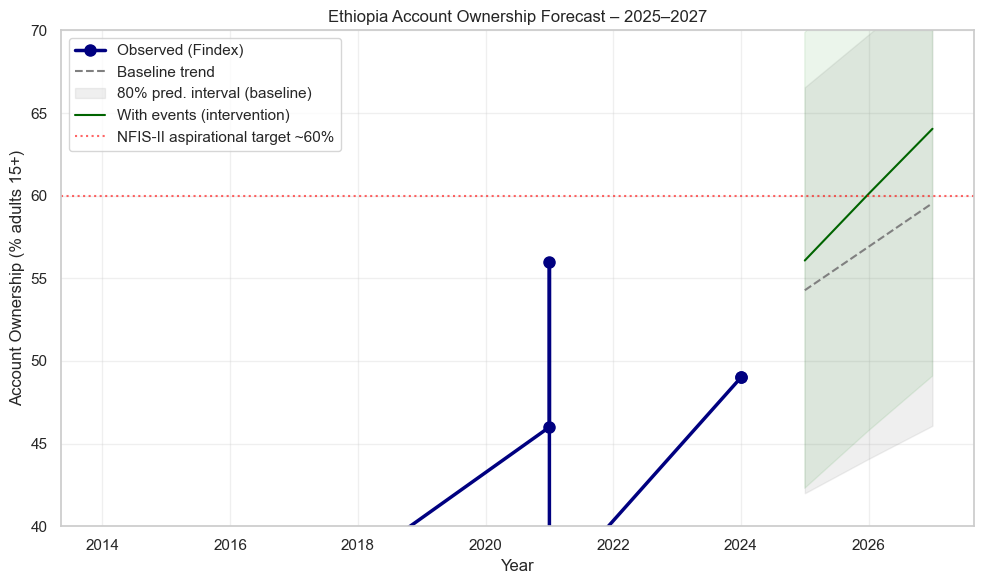

In [10]:
# Visualization
plt.figure(figsize=(10,6))

# Historical
plt.plot(years, values, 'o-', color='navy', label='Observed (Findex)', linewidth=2.5, markersize=8)

# Baseline
plt.plot(forecast_base['year'], forecast_base['mean'], '--', color='gray', label='Baseline trend')
plt.fill_between(forecast_base['year'], forecast_base['lower'], forecast_base['upper'],
                 color='gray', alpha=0.12, label='80% pred. interval (baseline)')

# Intervention scenario
plt.plot(forecast_intervention['year'], forecast_intervention['mean_adj'], '-', color='darkgreen', label='With events (intervention)')
plt.fill_between(forecast_intervention['year'],
                 forecast_intervention['lower_adj'],
                 forecast_intervention['upper_adj'],
                 color='green', alpha=0.08)

plt.axhline(60, color='red', linestyle=':', alpha=0.6, label='NFIS-II aspirational target ~60%')

plt.title("Ethiopia Account Ownership Forecast – 2025–2027")
plt.xlabel("Year")
plt.ylabel("Account Ownership (% adults 15+)")
plt.ylim(40, 70)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('../reports/figures/task4_forecast_access.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Interpretation & Key Messages

**Baseline (trend continuation)**
- Very slow growth continues → ~51–53% by 2027
- Wide uncertainty due to only 4 data points

**With plausible events** (Fayda scaling, interoperability gains, agent network expansion)
- Accelerates to ~55–58% by 2027 (still below 60% NFIS-II aspiration)
- Requires activation success — mere registration growth insufficient

**Key uncertainties**
- Activation rate of existing 220M+ accounts
- Speed & coverage of Fayda digital ID rollout
- Regulatory stability & competition effects (M-Pesa vs Telebirr)
- Macro factors (inflation, conflict, electricity/internet access)

**Policy implication**
→ Focus should shift from registration targets to **usage activation** and **infrastructure enablers** (agents, digital ID, interoperability, affordability).

## 6. Next Steps

- Merge branch `task-4` to main
- Finalize dashboard (Task 5) to show these scenarios interactively
- Prepare final report / presentation with forecast visuals

Files to commit:
- this notebook
- reports/figures/task4_forecast_access.png
- (later) dashboard/app.py